In [14]:
import os
import numpy as np
from glob import glob
import random
from tqdm import tqdm
from osgeo import gdal
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryCrossentropy
import import_ipynb
from Model_1 import ssunet 
from metrics import dice_loss, dice_coef, iou

In [15]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3686302772811607091
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13957378048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2133568002266830600
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [16]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
""" Hyperparameters """
batch_size = 32
lr = 1e-4
num_epochs = 100
height = 128
width = 128

In [18]:
""" Directory for storing files """
save_path = os.path.join("E:\\Koneksi\\Run_SAM_hr_8band\\Training")
model_path = os.path.join(save_path, "model.h5")
csv_path = os.path.join(save_path, "data.csv")

"""path"""
dataset_path = os.path.join("E:\\Koneksi\\Run_SAM_hr_8band\\Split_data\\")
train_path = os.path.join(dataset_path, "train\\")
valid_path = os.path.join(dataset_path, "val\\")
#test_path = os.path.join(dataset_path, "test\\")

In [19]:
"""load data train adn validation"""
def load_data(path):
    train_x = sorted(glob(os.path.join(train_path, "Image/*")))
    train_y = sorted(glob(os.path.join(train_path, "Mask/*")))
    
    valid_x = sorted(glob(os.path.join(valid_path, "Image/*")))
    valid_y = sorted(glob(os.path.join(valid_path, "Mask/*")))

    #test_x = sorted(glob(os.path.join(test_path, "Image/*")))
    #test_y = sorted(glob(os.path.join(test_path, "Mask/*")))
    
    return (train_x,train_y), (valid_x,valid_y)#, (test_x,test_y)

In [20]:
"""read image"""
def read_image(path):
    path = path.decode()
    x = gdal.Open(path).ReadAsArray()
    x = np.rollaxis(x, 0, 3)
    x = x/10000
    x = x.astype(np.float32)
    return x

In [21]:
"""read mask"""
def read_mask(path):
    path = path.decode()
    x = gdal.Open(path).ReadAsArray()
    #x[x == 2] = 1 
    #x = np.rollaxis(x, 0, 3)
    #x[np.isnan(x)] = 0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

In [22]:
"""tf.datapipeline"""
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 8])
    y.set_shape([height, width, 1])
    return x, y

In [23]:
def tf_dataset(x, y, batch=batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [24]:
"""training"""
#(train_x,train_y), (valid_x,valid_y), (test_x,test_y)= load_data(dataset_path)
(train_x,train_y), (valid_x,valid_y)= load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
#print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 2268 - 2268
Valid: 567 - 567


In [25]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [26]:
for x,y in train_dataset:
    print(x.shape, y.shape)
    break

(32, 128, 128, 8) (32, 128, 128, 1)


In [27]:
input_shape = (height, width, 8)
model = ssunet(input_shape)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 128, 128, 64  4672        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 64  0           ['conv2d_27[0][0]']              
                                )                                                           

In [29]:
opt = tf.keras.optimizers.Adam(lr)
metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [30]:
callbacks = [
    ModelCheckpoint(model_path,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [31]:
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/100
71/71 [==============================] - 35s 364ms/step - loss: 0.4512 - accuracy: 0.8578 - recall: 0.0347 - precision: 0.1458 - iou: 0.0722 - val_loss: 0.4146 - val_accuracy: 0.8812 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0848 - lr: 1.0000e-04
Epoch 2/100
71/71 [==============================] - 18s 254ms/step - loss: 0.3867 - accuracy: 0.8783 - recall: 0.0000e+00 - precision: 0.0000e+00 - iou: 0.0670 - val_loss: 0.4108 - val_accuracy: 0.8812 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0858 - lr: 1.0000e-04
Epoch 3/100
71/71 [==============================] - 18s 252ms/step - loss: 0.3793 - accuracy: 0.8783 - recall: 0.0000e+00 - precision: 0.0000e+00 - iou: 0.0629 - val_loss: 0.3651 - val_accuracy: 0.8812 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0693 - lr: 1.0000e-04
Epoch 4/100
71/71 [==============================] - 15s 215ms/step - loss: 0.3743 - accuracy: 0.8783 - recall: 0.0000e+00 - precision:

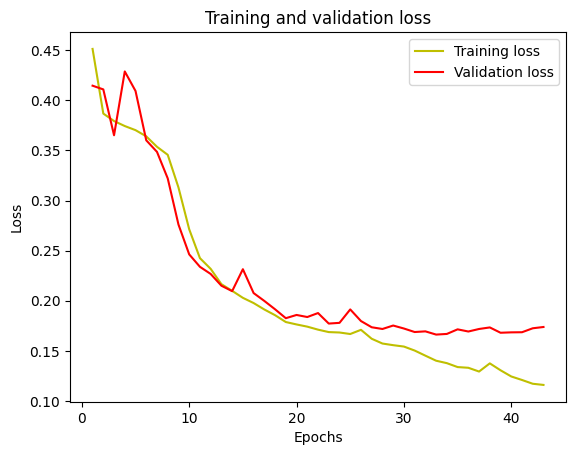

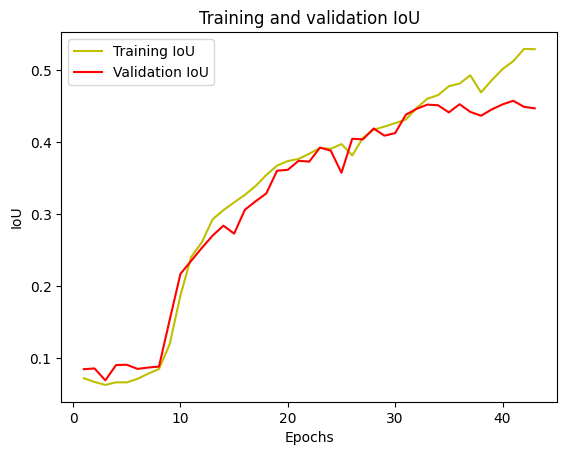

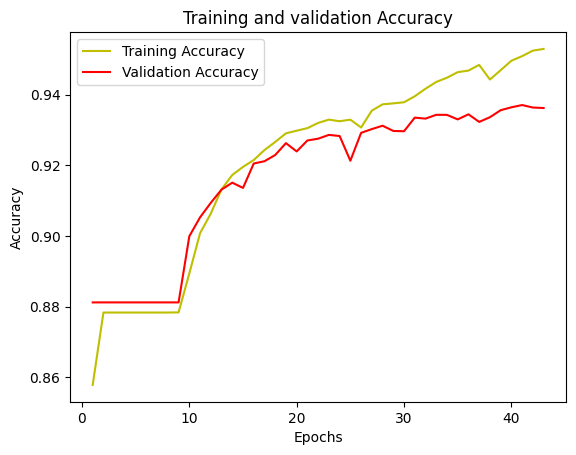

In [32]:
#plot the training and validation accuracy and loss at each epoch
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou']
val_acc = history.history['val_iou']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

accuracy =  history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [55]:
# evaluate model
test = model.evaluate(test_dataset, steps=test_steps)

9/9 [==============================] - 3s 291ms/step - loss: 0.2272 - accuracy: 0.9116 - recall_2: 0.5305 - precision_2: 0.6635 - iou: 0.2784
